## Sentiment Analysis on movie reviews scraped from IMDb

This NLP project is aim to a classifiers for movie review scraped from IMDb.com:

1. Crawl data from IMDb.com, the top-100 most popular movies by genre (total 20 genres - Action, Adventure ...), refer to the website - https://www.imdb.com/chart/moviemeter?ref_=nv_mv_mpm_8 . The code of the spider is in the document "Movie-crawler".
2. Sentiment Analysis, build a classifier to predict the sentiment of a review, positive or negative.

In [1]:
import numpy as np
import pandas as pd
import math
import re
import collections
import random
import string
import time

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectPercentile, chi2

import tensorflow as tf
import keras
import matplotlib.pyplot as plt

/Users/qiuruihao/miniconda2/envs/py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
Using TensorFlow backend.


### Binary classification

In [2]:
## input data
data_path = "Movie-crawler/IMDb/IMDb/spiders/reviews.csv"
origin_data = pd.read_csv(data_path)
origin_data = origin_data[np.isfinite(origin_data['rating'])]
origin_data = origin_data[pd.notnull(origin_data['review'])]
print(origin_data.shape)
corpus = origin_data.review.values
y = pd.cut(origin_data.rating.values, 2, labels=False)
print(corpus[:1])

(12999, 4)
[ "Your going to be hard pressed to find a movie more over the top than Deadpool 2, David leitch takes it to a whole new level entirely. It works namely because the violence here is just to creative. Sure it defies all Logic most of the time, but i was laughing and having a rip-roaring time throughout.,Go into this movie knowing that it is a campy, corny, over the top superhero/action/comedy that is just about crazy shooting sequences and one-liners, and you'll be fine. Do not go into this movie expecting deep plot, meaningful conversations among characters, or anything remotely resembling a serious action or drama movie. ,Loved it...."]


In [3]:
from collections import Counter

Counter(y)

Counter({0: 4435, 1: 8564})

In [4]:
## Clean text

def clean_doc(text):
    
    text=text.lower()
    tokens = text.split()
    
    table = str.maketrans("","", string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    
    tokens = [w for w in tokens if w.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

#    stemmer = SnowballStemmer('english')
#    tokens = [stemmer.stem(w) for w in tokens]
    
    tokens = [w for w in tokens if len(w) > 1]

    return tokens

clean_corpus = []
clean_words = []
for i, s in enumerate(corpus):
    clean_words.append(clean_doc(str(s)))
    clean_corpus.append(" ".join(clean_doc(s)))

print(clean_words[0])
print(clean_corpus[0])
print("Length of X:", len(clean_corpus))

['going', 'hard', 'pressed', 'find', 'movie', 'top', 'deadpool', 'david', 'leitch', 'takes', 'whole', 'new', 'level', 'entirely', 'works', 'namely', 'violence', 'creative', 'sure', 'defies', 'logic', 'time', 'laughing', 'riproaring', 'time', 'throughoutgo', 'movie', 'knowing', 'campy', 'corny', 'top', 'superheroactioncomedy', 'crazy', 'shooting', 'sequences', 'oneliners', 'youll', 'fine', 'go', 'movie', 'expecting', 'deep', 'plot', 'meaningful', 'conversations', 'among', 'characters', 'anything', 'remotely', 'resembling', 'serious', 'action', 'drama', 'movie', 'loved']
going hard pressed find movie top deadpool david leitch takes whole new level entirely works namely violence creative sure defies logic time laughing riproaring time throughoutgo movie knowing campy corny top superheroactioncomedy crazy shooting sequences oneliners youll fine go movie expecting deep plot meaningful conversations among characters anything remotely resembling serious action drama movie loved
Length of X: 1

### Word embedding

- Train word embedding + PCA + visualization
- embedding + LSTM
- embedding + CNN + LSTM

In [5]:
## train embedding with word2vec
from gensim.models import Word2Vec
import random

start = time.time()
model = Word2Vec(clean_words, size=200, min_count=5)
print(time.time()-start)

204.91223287582397


In [6]:
import scipy.spatial as sp

words = list(model.wv.vocab)
final_embeddings = model[model.wv.vocab]

#similarity = 1 - sp.distance.cdist(final_embeddings, final_embeddings, 'cosine')
Anorm = final_embeddings / np.linalg.norm(final_embeddings, axis=-1)[:, np.newaxis]
similarity = np.dot(Anorm, Anorm.T)

random.seed(99)
random_list = random.sample(range(len(words)), 10)
for i in random_list:
    top_sim = (-similarity[i,:]).argsort()[1:11]
    print("nearest neighbors of {0}: ".format(words[i]), end="")
    for k in top_sim:
        print(words[k], end=" ")
    print()

/Users/qiuruihao/miniconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


nearest neighbors of lunatics: practice waving cigarettes spiders tactic therapy leather immune shark contests 
nearest neighbors of flames: hometown worms seaside protest forcibly senate amok hopping cusp clovers 
nearest neighbors of dimas: assassinate photographs enraged regions walnut aires groupies apache locals operating 
nearest neighbors of shields: lesbians breakers fraudulent principled xenophobic taxi gloves invisible hurricane birds 
nearest neighbors of lightyear: morris lane stint transportation spacecraft evangeline wessel handley shirley singles 
nearest neighbors of extensively: royalty alcoholism disastrous contracted beanes adhering devise dday hayes ottoman 
nearest neighbors of humanoids: cecilia territory pappy poppy paula republican bannister mutual feud demented 
nearest neighbors of bombastic: seriousness explicit sentimentality glossy steeped shockingly suggestive overblown titillating selfconscious 
nearest neighbors of cazale: keanu cromwell meek durand mitc

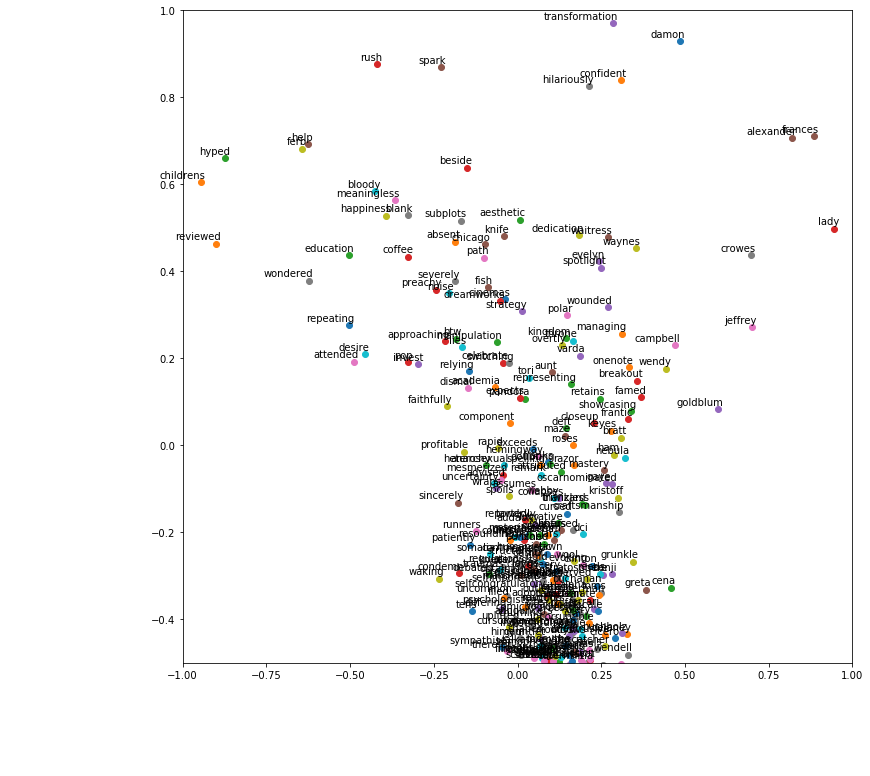

In [13]:
from sklearn.decomposition import PCA

def plot_with_labels(low_dim_embs, labels):
  plt.figure(figsize=(12, 12))
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.xlim(-1,1)
    plt.ylim(-0.5,1)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

n_plot = 300
pca = PCA(n_components=2)
result = pca.fit_transform(final_embeddings[:n_plot, :])

labels = [words[i] for i in range(n_plot)]
plot_with_labels(result, labels)

In [14]:
## build vocabulary

def count_data(words, n_words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:
      unk_count += 1
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return count, dictionary, reversed_dictionary

## words are indexed by overall frequency in the dataset, 
## so that for instance the integer "3" encodes the 3rd most frequent word in the data. 
def build_data(sep_words):
  data = list()
  for lst in clean_words:
    sent = list()
    for w in lst:
      if w in dictionary.keys():
        sent.append(dictionary[w])
      else:
        sent.append(dictionary["UNK"])
    data.append(sent)
  return data

vocab_size = 10000
all_words = np.concatenate(clean_words)
count, dictionary, reverse_dictionary = count_data(all_words, vocab_size)
data = build_data(clean_words)

print('Most common words (+UNK)', count[:10])
print("5 sample sentences:")
for i in range(1):
  print([reverse_dictionary[j] for j in data[i]], data[i], sep="\n")

Most common words (+UNK) [['UNK', 193830], ('movie', 17548), ('film', 16195), ('one', 13516), ('like', 12243), ('show', 11278), ('story', 8361), ('good', 7897), ('time', 7152), ('really', 7149)]
5 sample sentences:
['going', 'hard', 'pressed', 'find', 'movie', 'top', 'deadpool', 'david', 'UNK', 'takes', 'whole', 'new', 'level', 'entirely', 'works', 'namely', 'violence', 'creative', 'sure', 'defies', 'logic', 'time', 'laughing', 'UNK', 'time', 'UNK', 'movie', 'knowing', 'campy', 'corny', 'top', 'UNK', 'crazy', 'shooting', 'sequences', 'oneliners', 'youll', 'fine', 'go', 'movie', 'expecting', 'deep', 'plot', 'meaningful', 'conversations', 'among', 'characters', 'anything', 'remotely', 'UNK', 'serious', 'action', 'drama', 'movie', 'loved']
[59, 151, 9087, 79, 1, 216, 2243, 588, 0, 180, 117, 46, 523, 909, 389, 4888, 484, 1041, 136, 9584, 2123, 8, 849, 0, 8, 0, 1, 1100, 4354, 1951, 216, 0, 725, 1351, 786, 3252, 399, 433, 50, 1, 736, 639, 44, 2721, 3199, 649, 12, 131, 3012, 0, 517, 108, 192,

In [15]:
## embedding + LSTM

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.layers import LSTM
from keras.preprocessing import sequence

np.random.seed(7)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=99, stratify=y)

vector_length = 100
#sent_lens = [len(s) for s in clean_words]
#sentence_length = np.round((np.mean(sent_lens) + 2*np.std(sent_lens))).astype(int)
#print(sentence_length)
sentence_length = 300

X_train = sequence.pad_sequences(X_train, maxlen=sentence_length)
X_test = sequence.pad_sequences(X_test, maxlen=sentence_length)

#print(y_train[:10]-1)
#Y_train = keras.utils.to_categorical(y_train, 10)
#Y_test  = keras.utils.to_categorical(y_test, 10)

print(X_train.shape, X_test.shape)
#print(X_train[:10])

(10399, 300) (2600, 300)


In [93]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=vector_length, input_length=sentence_length))
model.add(Dropout(0.5))
model.add(LSTM(64, dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=32)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 300, 100)          1000000   
_________________________________________________________________
dropout_16 (Dropout)         (None, 300, 100)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 1,042,305
Trainable params: 1,042,305
Non-trainable params: 0
_________________________________________________________________
None
Train on 10399 samples, validate on 2600 samples
Epoch 1/3
10399/10399 [==============================] - 127s 12ms/step - loss: 0.5103 - acc: 0.7431 - val_loss: 0.3580 - val_acc: 0.8531
Epoch 2/3
10399/10399 [==============================] - 141s 14ms/step 

In [94]:
## Embedding + LSTM + CNN
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=vector_length, input_length=sentence_length))
model.add(Dropout(0.2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.2))
#model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
#model.add(Dropout(0.2))
model.add(LSTM(64, dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 300, 100)          1000000   
_________________________________________________________________
dropout_17 (Dropout)         (None, 300, 100)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 300, 32)           9632      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 75, 32)            0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 75, 32)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total para